## utils

### geometric util

In [5]:
import numpy as np
import quaternion
from shapely.geometry import Polygon
import trimesh

def vec_to_trans(vec):
    a = np.identity(len(vec)+1)
    a[:len(vec),len(vec)] = vec
    return a

def add_dimension(points, value=0):
    return np.concatenate([points[np.newaxis,:,i].T if i<len(points[0]) else np.full([len(points),1], value) for i in range(len(points[0])+1)], 1)
    
def get_square_horizon(base_pos, radius, z_angle=0):
    d1 = [1,1,-1,-1]
    d2 = [1,-1,-1,1]
    poss = np.array([np.quaternion(1,d1[i]*radius,d2[i]*radius,0) for i in range(4)])
    q = quaternion.from_euler_angles(0,0,z_angle)
    pq = q*poss*q.conj()
    
    return np.array([[p.x, p.y, p.z] for p in pq])+base_pos

def get_extended_face(face_vertices, length):
    face_bottom = np.copy(face_vertices)
    face_bottom[:,2] += length
    return np.concatenate([face_vertices, face_bottom])
    
def distance_filtered_poly(polygon, distance=0.01):
    c = np.round(polygon.exterior.coords, 3)
    ban = np.zeros([len(c)], dtype=int)
    for i in range(len(c)):
        if not ban[i]:
            n = np.linalg.norm(c-c[i], axis=1) < distance
            n[i] = False
            ban = np.logical_or(ban, n) 
    
    return Polygon(c[np.logical_not(ban)])

/usr/local/lib/python2.7/dist-packages/quaternion/numba_wrapper.py:21: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


### shape util

In [6]:
def get_mesh_from_model(model):
    col = model.get_link_by_name(model.name).collisions[0]
    col_mesh_before_trans = col.geometry._geometry_entity.get_meshes()[0]

    return col_mesh_before_trans, col.pose.position

def get_corrected_mesh_from_model(model):
    import copy
    
    mesh, t = get_mesh_from_model(model)
    c_mesh = copy.deepcopy(mesh)
    c_mesh.apply_transform(vec_to_trans(t)) #-
    return c_mesh

def get_poly_from_model(model, mesh_slice_height): ## height; ROOM_WALL_HEIGHT/2
    c_mesh = get_corrected_mesh_from_model(model)
    poly = trimesh.path.polygons.projected(c_mesh, (0,0,mesh_slice_height))
    return poly

def get_interior_poly_from_extrude_mesh(mesh, mesh_slice_height):
    extrude_poly = trimesh.path.polygons.projected(mesh, (0,0,mesh_slice_height))
    return distance_filtered_poly(Polygon(extrude_poly.interiors[0]))

def get_interior_poly_from_extrude_model(model, mesh_slice_height):
    extrude_poly = get_poly_from_model(model, mesh_slice_height)
    extrude_interior_poly = distance_filtered_poly(Polygon(extrude_poly.interiors[0])) #-
    return extrude_interior_poly

## model manager

In [7]:
from pcg_gazebo.task_manager import ProcessManager
import shapely
from shapely.geometry.polygon import Polygon
from sklearn.cluster import DBSCAN
import trimesh
import copy

from pcg_gazebo.simulation.properties.pose import Pose

from pcg_gazebo.generators.creators import create_models_from_config

class ModelManager(): ## orientation: [roll, pitch, yaw] (degrees) or [qx, qy, qz, qw] (quaternion)
    
    namespace = 0
    
    def __init__(self, gazebo_proxy):
        self.gazebo_proxy = gazebo_proxy
        self.namespace = ModelManager.namespace
        ModelManager.namespace += 1
        self.configspaces = dict()
        self.modelspaces = dict()
    
    def is_set_modelspace(self, tag):
        return tag in self.modelspaces.keys()
        
    def set_modelspace_from_config(self, tag, config, max_model_count, disable_collision=False):
        configs = [copy.deepcopy(config)[0] for _ in range(max_model_count)]
        for i in range(max_model_count):
            configs[i]['args']['name'] = "mm-{}-{}_{}".format(self.namespace, tag, i)
        
        self.configspaces[tag] = configs
        models = create_models_from_config(configs)
        
        if disable_collision:
            for m in models:
                m.get_link_by_name('link').disable_collision()
        
        self.modelspaces[tag] = models
        
    def set_modelspace_from_models(self, tag, models):
        for i in range(len(models)):
            models[i].name = "mm-{}-{}_{}".format(self.namespace, tag, i)
            self.modelspaces[tag][i] = models[i]
        
    def get_moved_models(self, tag, positions, orientations):
        copy_models = copy.deepcopy(self.modelspaces[tag][:len(positions)])
        
        poses = [Pose(pos=p, rot=o) for p,o in zip(positions, orientations)]
        for i in range(len(positions)):
            copy_models[i].pose += poses[i]
        
        return copy_models
    
    def get_base_models(self, tag, count):
        return self.modelspaces[tag][0:count]
        
    def get_base_model_poses(self, tag, count):
        return [self.modelspaces[tag][i].pose for i in range(count)]
            
    def apply_model(self, tag, positions, orientations):
        self._delete_other_models()
        self._delete_models(tag, len(positions), len(self.modelspaces[tag]))
            
        for i in range(len(positions)):
            self.modelspaces[tag][i].spawn(
                gazebo_proxy=self.gazebo_proxy, 
                robot_namespace=self.modelspaces[tag][i].name,
                pos=list(positions[i]),
                rot=list(orientations[i])
            )

    def _is_mine_model(self, model_name):
        namespace = model_name.split("-")[1]
        return ModelManager._is_manager_model(model_name) and namespace == str(self.namespace)
    
    @classmethod
    def _is_manager_model(cls, model_name):
        name = model_name.split("-")
        return name[0] == "mm" and str.isdigit(name[1])

    def _delete_models(self, tag, start, stop):
        for i in range(start, stop):
            self.gazebo_proxy.delete_model(model_name="mm-{}-{}_{}".format(self.namespace, tag, i))

    def _delete_other_models(self):
        models = self.gazebo_proxy.get_model_names()
        manager_models = filter(ModelManager._is_manager_model, models)
        other_models = filter(lambda m: not self._is_mine_model(m), manager_models)
        
        for m in other_models:
            self.gazebo_proxy.delete_model(model_name=m)

### ModelManager test

In [7]:
from pcg_gazebo.task_manager import GazeboProxy

import numpy as np

TARGET_SIM = dict(
    ros_host='localhost',
    ros_port=11311,
    gazebo_host='localhost',
    gazebo_port=11345
)

gazebo_proxy = GazeboProxy(**TARGET_SIM)

model_manager = ModelManager(gazebo_proxy)
box_config = [
    dict(
        type='box',
        args=dict(
            size=[0.5,0.5,0.5],
            name='tameshi',
            color='random'
        )
    )
]

model_manager.set_modelspace_from_config('tameshi', box_config, 10)
model_manager.apply_model('tameshi', np.random.random(size=(5,3))*4, np.random.randint(0,360,(5,3)))


In [8]:
state0 = gazebo_proxy.get_model_state(model_name='mm-0-tameshi_0')
state1 = gazebo_proxy.get_model_state(model_name='mm-0-tameshi_1')
print(state1.pose)
models = model_manager.get_base_models(tag='tameshi', count=2)
print(models[0].pose)

position: 
  x: 3.11532
  y: 1.02172
  z: 1.48036
orientation: 
  x: 0.0539490595026
  y: -0.460835669637
  z: 0.438358255751
  w: 0.7697805039
Position (x, y, z) [m]: 0, 0, 0
	 - x: 0
	 - y: 0
	 - z: 0
Orientation rpy (roll, pitch, yaw) (degrees): 
	 - Roll: 0.0
	 - Pitch: -0.0
	 - Yaw: 0.0



In [9]:
import copy
from pcg_gazebo.simulation.properties.pose import Pose

cm_pose = Pose(
    pos=[
        state1.pose.position.x, 
        state1.pose.position.y, 
        state1.pose.position.z
    ],
    rot=[
        state1.pose.orientation.x, 
        state1.pose.orientation.y, 
        state1.pose.orientation.z, 
        state1.pose.orientation.w
    ]
)

# cm = copy.deepcopy(models[0])
# cm.pose = cm_pose

cm = model_manager.get_moved_models(tag='tameshi', positions=[cm_pose.position], orientations=[cm_pose.rpy])

print(cm[0].pose)

print(cm[0].pose.quat)

cm[0].spawn(gazebo_proxy=gazebo_proxy)

Position (x, y, z) [m]: 3.11532, 1.02172, 1.48036
	 - x: 3.11532
	 - y: 1.02172
	 - z: 1.48036
Orientation rpy (roll, pitch, yaw) (degrees): 
	 - Roll: -29.4077463844
	 - Pitch: -49.1813793311
	 - Yaw: 73.0154495803

[ 0.05394906 -0.46083567  0.43835826  0.7697805 ]


True

In [10]:
gazebo_proxy.delete_model(model_name=models[1].name)

True

## room generator factory method

In [21]:
import abc

import numpy as np
import shapely

from shapely.geometry import Polygon
from pcg_gazebo.task_manager import GazeboProxy
from pcg_gazebo.simulation.world import World
from pcg_gazebo.simulation.model import SimulationModel
            
class RoomGeneratorFactory(object):

    def __init__(self, ros_host="localhost", ros_port=11311, gazebo_host='localhost', gazebo_port=11345):
        self.gazebo_proxy = GazeboProxy(
            ros_host=ros_host,
            ros_port=ros_port,
            gazebo_host=gazebo_host,
            gazebo_port=gazebo_port
        )
        self.model_manager = ModelManager(self.gazebo_proxy)
        
    @abc.abstractmethod
    def generate_new(self): ## return RoomConfig
        pass
        
        
class RoomConfig(object):
    
    def __init__(self, model_manager):
        self.model_manager = model_manager
        self.spawn_config = dict() ## 'tag': {'config_base': ~, 'positions': ~, 'orientations': ~}
        self.tags = list()
        
    @abc.abstractmethod
    def prepare_model_manager(self):
        pass
    
    def register_empty(self, tag, config_base, count):
        self.tags.append(tag)
        self.spawn_config[tag] = dict(
            config_base=config_base,
            positions=np.zeros([count,3]),
            orientations=np.zeros([count,3])
        )
    
    def register_positions(self, tag, positions):
        self.spawn_config[tag]['positions'] = positions
        
    def register_orientations(self, tag, orientations):
        self.spawn_config[tag]['orientations'] = orientations
    
    def set_modelspace_force(self, tag, disable_collision=False):
        self.model_manager.set_modelspace_from_config(
            tag, 
            self.spawn_config[tag]['config_base'], 
            len(self.spawn_config[tag]['positions']),
            disable_collision=disable_collision
        )
    
    def set_modelspace(self, tag, disable_collision=False):
        if not self.model_manager.is_set_modelspace(tag):
            self.set_modelspace_force(tag, disable_collision)
        
    def spawn_all(self):
        for t in self.spawn_config.keys():
            self.model_manager.apply_model(t, self.spawn_config[t]['positions'], self.spawn_config[t]['orientations'])
    
    def _get_all_moved_models(self, exclude_tags=[None]):
        moved = [
            self.model_manager.get_moved_models(
                tag, 
                self.spawn_config[tag]['positions'],
                self.spawn_config[tag]['orientations']
            ) for tag in self.tags if not tag in exclude_tags
        ]
        models = {}
        for ms in moved:
            for m in ms:
                models[m.name] = m
                
        return models
    
    @abc.abstractmethod
    def get_freespace_poly(self, exterior_wall_tag, exclude_tags=[None]):
        from pcg_gazebo.generators.occupancy import generate_occupancy_grid
        
        wall_name = self.model_manager.get_base_models(exterior_wall_tag, 1)[0].name
        
        models = self._get_all_moved_models(exclude_tags=exclude_tags)
        models['ground_plane'] = SimulationModel.from_gazebo_model('ground_plane')
        
        occ_poly = generate_occupancy_grid(models, ground_plane_models=[wall_name])
        
        space = Polygon(occ_poly['static']['ground_plane_models'].interiors[0])

        ex = ['ground_plane', 'ground_plane_models']
        interior_polys = [occ_poly['static'][name] for name in occ_poly['static'].keys() if not name in ex]
        union_poly = shapely.ops.unary_union(interior_polys)
        
        return Polygon(list(space.exterior.coords), [list(p.exterior.coords) for p in union_poly])
        
    @abc.abstractmethod
    def get_occupancy_grid(self, exterior_wall_tag, exclude_tags=[None]):
        from pcg_gazebo.visualization import plot_occupancy_grid
        import io
        import cv2
        
        wall_name = self.model_manager.get_base_models(exterior_wall_tag, 1)[0].name
        
        models = self._get_all_moved_models(exclude_tags=exclude_tags)
        models['ground_plane'] = SimulationModel.from_gazebo_model('ground_plane')        
        
        fig = plot_occupancy_grid(
            models,
            with_ground_plane=True,
            static_models_only=False,
            exclude_contains=['ground_plane'],
            ground_plane_models=[wall_name]
        )

        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        enc = np.frombuffer(buf.getvalue(), dtype=np.uint8)
        dst = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)
        
        return dst
        

## cube room generator

In [22]:

class CubeRoomConfig(RoomConfig):
    
    def __init__(self, 
                 model_manager,
                 wall_polygon, 
                 wall_thickness,
                 wall_height,
                 obstacle_size, 
                 target_size,
    ):
        
        super(CubeRoomConfig, self).__init__(model_manager)
        
        self.wall_polygon = wall_polygon
        self.wall_thickness = wall_thickness
        self.wall_height = wall_height
        self.obstacle_size = obstacle_size
        self.target_size = target_size
        
        self.wall_tag = 'wall'
        self.obstacle_tag = 'obstacle'
        self.target_tag = 'target'
        
        self.wall_color = 'black'
        self.obstacle_color = 'white'
        self.target_color = 'cyan'
        
        self.wall_config_base = [
            dict(
                type='extrude',
                args=dict(
                    polygon=wall_polygon,
                    height=wall_height,
                    thickness=wall_thickness,
                    extrude_boundaries=True,
                    name=self.wall_tag,
                    color=self.wall_color
                )
            )
        ]
        
        self.obstacle_config_base = [
            dict(
                type='box',
                args=dict(
                    size=obstacle_size,
                    name=self.obstacle_tag,
                    color=self.obstacle_color
                )
            )
        ]
        
        self.target_config_base = [
            dict(
                type='box',
                args=dict(
                    size=target_size,
                    name=self.target_tag,
                    color=self.target_color
                )
            )
        ]

    def prepare_model_manager(self, max_obstacle_count, max_target_count):
        self.register_empty(self.wall_tag, self.wall_config_base, 1)
        self.set_modelspace_force(self.wall_tag)
        
        self.register_empty(self.obstacle_tag, self.obstacle_config_base, max_obstacle_count)
        self.set_modelspace(self.obstacle_tag)
        
        self.register_empty(self.target_tag, self.target_config_base, max_target_count)
        self.set_modelspace(self.target_tag, disable_collision=True)
        
        
    def set_components_pose(self, obstacle_poss, obstacle_oris, target_poss, target_oris):
        self.register_positions(self.wall_tag, [[0,0,self.wall_height/2]])
        self.register_positions(self.obstacle_tag, obstacle_poss)
        self.register_orientations(self.obstacle_tag, obstacle_oris)
        self.register_positions(self.target_tag, target_poss)
        self.register_orientations(self.target_tag, target_oris)
            
    @property
    def wall_model(self):
        if self.model_manager.is_set_modelspace(self.wall_tag):
            return self.model_manager.get_base_models(self.wall_tag, 1)[0]
        else:
            return None
    
    @property
    def obstacle_models(self):
        c = len(self.spawn_config[self.obstacle_tag]['positions'])
        if self.model_manager.is_set_modelspace(self.obstacle_tag):
            return self.model_manager.get_base_models(self.obstacle_tag, c)
        else:
            return None
        
    @property
    def target_models(self):
        c = len(self.spawn_config[self.target_tag]['positions'])
        if self.model_manager.is_set_modelspace(self.target_tag):
            return self.model_manager.get_base_models(self.target_tag, c)
        else:
            return None
        
        
from pcg_gazebo.generators.shapes import random_points_to_triangulation
import shapely
from shapely.geometry.polygon import Polygon
from sklearn.cluster import DBSCAN
import trimesh
import copy
        
class CubeRoomGenerator(RoomGeneratorFactory):
    
    def __init__(self,
                 obstacle_count=10,
                 obstacle_size=0.7,
                 agent_size=0.3,
                 target_size=0.2,
                 room_length_max=9,
                 room_mass_min=20,
                 room_mass_max=36,
                 room_wall_height=0.8,
                 room_wall_thickness=0.05,
                 wall_threshold=0.1,
                 ros_host="localhost", ros_port=11311, gazebo_host='localhost', gazebo_port=11345):
        
        super(CubeRoomGenerator, self).__init__(ros_host, ros_port, gazebo_host, gazebo_port)
        
        self.obstacle_count = obstacle_count
        self.obstacle_size = obstacle_size
        self.agent_size = agent_size
        self.target_size = target_size
        self.room_length_max = room_length_max
        self.room_mass_min = room_mass_min
        self.room_mass_max = room_mass_max
        self.room_wall_height = room_wall_height
        self.room_wall_thickness = room_wall_thickness
        self.wall_threshold = wall_threshold
        
    def _create_wall_poly(self):
        while True:
            poly = random_points_to_triangulation(
                x_min=-self.room_length_max/2,
                x_max=self.room_length_max/2,
                y_min=-self.room_length_max/2,
                y_max=self.room_length_max/2
            )
            area = poly.area
            if self.room_mass_max >= area and area >= self.room_mass_min:
                return poly
    
    def generate_new(self):
        wall_base = self._create_wall_poly()
        
        room_instance = CubeRoomConfig(
                model_manager=self.model_manager,
                wall_polygon=wall_base, 
                wall_thickness=self.room_wall_thickness,
                wall_height=self.room_wall_height,
                obstacle_size=[self.obstacle_size for _ in range(3)], 
                target_size=[self.target_size for _ in range(3)]
        )
        
        room_instance.prepare_model_manager(self.obstacle_count, self.obstacle_count)
        
        wall_model = room_instance.wall_model
        
        wall_mesh = get_corrected_mesh_from_model(wall_model) #-
        wall_interior_poly = get_interior_poly_from_extrude_mesh(wall_mesh, self.room_wall_height/2) #-
        
        obstacle_poss, obstacle_oris = self.generate_obstacles_pose(wall_interior_poly)
        
        obstacle_label = self.get_cluster(np.sqrt((self.obstacle_size**2)*2)+self.agent_size/2, obstacle_poss)
        
        obstacle_zone_points, obstacle_zone_polys, obstacle_zone_hulls = self.create_zones_with_obstacle(
            obstacle_label, obstacle_poss, obstacle_oris
        )
        
        target_poss = self.generate_targets_pose(obstacle_zone_hulls)
        
        room_instance.set_components_pose(
            obstacle_poss=obstacle_poss, 
            obstacle_oris=obstacle_oris, 
            target_poss=target_poss,
            target_oris=np.zeros_like(target_poss)
        )
        
        return room_instance
        
    def generate_obstacles_pose(self, wall_interior_poly):
        sample_area = wall_interior_poly.buffer(-1*(self.wall_threshold+self.obstacle_size)) #+
        pos = trimesh.path.polygons.sample(sample_area, self.obstacle_count) #-
        pos = add_dimension(pos, self.obstacle_size/2) #-
        
        ori = np.zeros_like(pos)
        ori[:,2] = np.random.random([len(pos)])*np.pi*2
        
        return pos, ori
    
    def generate_targets_pose(self, zone_hulls):
        zone_samples = [None]*len(zone_hulls)
        for i in range(len(zone_samples)):
            ## sample_surface return tuple, so choice 0 index
            samples = trimesh.sample.sample_surface_even(zone_hulls[i], 100)[0]
            zone_samples[i] = samples[
                np.logical_and(
                    np.not_equal(samples[:,2], 0), 
                    np.not_equal(samples[:,2], self.obstacle_size)
                )
            ]

        choiced_goal = np.zeros([len(zone_hulls),3])
        for i in range(len(choiced_goal)):
            choiced_goal[i] = zone_samples[i][np.random.choice(range(len(zone_samples[i])))]

        choiced_goal[:,2] = self.target_size/2
        
        return choiced_goal
        
    def create_zones_with_obstacle(self, label, positions, orientations):
        cls_count = max(label)+1
        
        zone_vertices_2d = [None]*cls_count
        zone_polys = [None]*cls_count
        for i in range(cls_count):
            pts = positions[label==i]
            rts = orientations[label==i]
            vertices = [get_square_horizon(p, self.obstacle_size/2, r[2]) for p,r in zip(pts,rts)] #-
            vertices_all = np.concatenate(vertices)

            zone_vertices_2d[i] = trimesh.convex.hull_points(vertices_all[:,:2])
            zone_polys[i] = shapely.ops.unary_union([Polygon(v) for v in vertices])
            
        zone_hulls = [None]*cls_count
        for i in range(cls_count):
            p3 = np.zeros([len(zone_vertices_2d[i]),3])
            p3[:,:2] = zone_vertices_2d[i]
            zone_hulls[i] = trimesh.Trimesh(vertices=get_extended_face(p3, self.obstacle_size)).convex_hull #-
            
        return zone_vertices_2d, zone_polys, zone_hulls
        
        
    def get_cluster(self, eps, points): ## eps; np.sqrt((OBSTACLE_SIZE**2)*2)+AGENT_SIZE/2
        db = DBSCAN(eps=eps, min_samples=1).fit(np.array(points))
        return db.labels_

#### CubeRoomGenerator test

In [23]:
c = CubeRoomGenerator(obstacle_count=10)

In [30]:
generated_room = c.generate_new()
generated_room.spawn_all()

In [31]:
# print(generated_room.spawn_config)

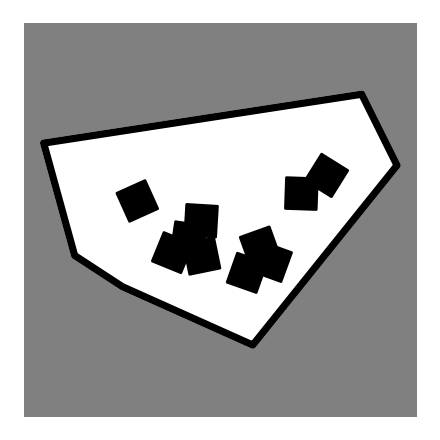

In [32]:
occupancy_grid = generated_room.get_occupancy_grid('wall', ['target'])
freespace_poly = generated_room.get_freespace_poly('wall', ['target'])

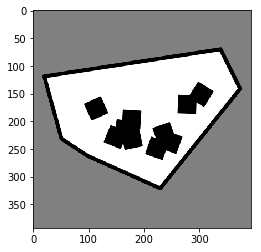

In [33]:
import matplotlib.pyplot as plt
plt.imshow(occupancy_grid, cmap='gray')

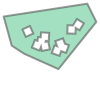

In [34]:
freespace_poly